# Reddit Clustering

For this project, we set to explore the topography of reddit. We wanted to see what subreddits are commonly used between users, if there are communities of users that act as links between subreddits, and if there are subreddits isolated from the main users' network of Reddit.

## Research Question

We are interested in clustering subreddits, by using comment and submission data to discern connections between subreddits and the users who are active in them. We are hoping to see similar userbases in subreddits we did not expect, along with disconnects in userbases between subreddits that appear intuitively similar. We want to use a Clustering algorithm to connect subreddits in space, and then calculate the distance between subreddits.We are interested in clustering subreddits, by using comment and submission data obtained from PRAW to discern connections between subreddits and the users who are active in them. We are hoping to see similar userbases in subreddits we did not expect, along with disconnections in userbases between subreddits that appear intuitively similar. We want to use a Clustering algorithm to connect subreddits in space, and then calculate the distance between subreddits. 

For the former part of research, we mainly focused on obtaining data set including reddit user, their comments and submissions for subreddits, cleaning out unnecessary features and pre-processing data for further exploration. Simple visualization of reddit posts distribution, relations between user posts number and posted subreddit number was displayed, which none of them has suggested significant results so far. For over 22,000 subreddits, there is a large portion with few data included, and handling this majority is believed to affect the following data analysis significantly. Multi-dimensional vectors implemented with array structure are also the major sources to perform data exploration and clustering on.

For the latter part, the main purpose will be completing data pre-processing,  figuring out correct application of Clustering Algorithm(method to choose, cluster number etc.) and displaying final visualization. The statistical analysis should also suggest some insights into the correlation among different subreddits and their active user community.

Several questions are expected to be answered while we proceed:

- How should we filter out the large amount of subreddits with few comments by simply removing the data or considering imputation methods? How should we determine a proper threshold for unpopular subreddits?

- K-means Clustering Algorithm seems to work for current data, but instead of presuming the number of classification arbitrarily, is there any statistical domain knowledge or library function we can refer to for more reliable output?

- The visualization in 2D space apparently fails to display more original properties for our multidimensional vectors. We need to implement proper functions to display more comprehensive data visualization, perhaps by using dimensionality reduction approach.


## Data Sources

All of our data is coming from reddit. Reddit submission and comment data is publicly accessible, and reddit has a nice API structure. We are using the package PRAW (python reddit api wrapper), which makes the reddit api calls easier to use and python importable. We are attempting to build subreddit comment vectors for a large number of reddit users. We would like to create nested dictionaries, the first level key being a reddit user, the second level keys being a subreddit name, and the values being how many time that specific user posted to a specific subreddit. 

Another important note is there are two kinds of ways to post to reddit, and the api distinguishes them. There are submissions and comments. Submissions are posts including an image, a video, or a question, and comments are replies and follow-ups to posts. Both kinds of posts on reddit are useful for the clustering we want to do, so we must do both.

We split our data scripts into different pieces, below is the documentation for each script, followed by the code. 

Also to gather any data from Reddit we must log on to the system with a developer id and create a reddit instance in our code. This happens once below.

In [1]:
import praw
import pandas as pd
import sys
import numpy as np

reddit = praw.Reddit(client_id='tc_fFbWZrkDSRw',
                     client_secret='fTq7nFVzdkCHFZY7jWQvHmkLpwk',
                     user_agent='lhimelman')

# userNameScraper.py:
  *A Scraper that gets just usernames, does it very quickly. 6000 usernames can be collected in a few minutes*

  EX: 
      
      
      python3 userNameScraper.py *saveFilename* *ListofSubreddit* *numberofpoststolookat*
      
      python3 userNameScraper.py data.txt funny,pics,todayilearned 100

In [2]:
def scrapeUsers(reddit, subredditList, postNum):
    subnum = 0
    for subredditname in subredditList:
        users = []
        posts = reddit.subreddit(subredditname).hot(limit=postNum)
        pc = 0
        for submission in posts:
            all_comments = submission.comments.list()
            for c in all_comments:
                try:
                    name = c.author.name
                    if name not in users:
                        users.append(name)
                except:
                    pass
            pc = pc + 1
            print( pc, "post")
        subnum = subnum + 1
        print( subnum, "subreddit")
    return users

##An example call scraping one post from r/funny
users = scrapeUsers(reddit,['politics'],1)
users

1 post
1 subreddit


['Thoramel',
 'Hrekires',
 'Sip_py',
 'dallasmorningnews',
 'jimbozak',
 'TransQuantinentalAce',
 'darkseadrake',
 'GotOutOfCowtown',
 'bivalve_attack',
 'becauseineedone3',
 'TrumpImpeachedAugust',
 'DistillateMedia',
 'wjbc',
 'neverliveindoubt',
 'HorsecockBillionaire',
 'MaimedJester',
 'PrincessSandySparkle',
 'Burning_Lovers',
 'Choco316',
 'Communist99',
 'esteban1386',
 'Schkateboarda',
 'nuncio-tc',
 'IMAVINCEMCMAHONGUY',
 'all2neat',
 'not-working-at-work',
 'garybusey42069',
 'erratically_sporadic',
 '10iss',
 'Vernacularry',
 'wisdom_and_frivolity',
 'halebara01',
 'ThrowAway_Phone',
 'ericolinn',
 'KellyJoyCuntBunny',
 'JacenGraff',
 'Roidciraptor']

# ScrapeFreqfromUser.py:
  *A scraper that gets frequencies of comments from a list of users*

  EX: 
    
        python3 ScrapeFreqfromUser.py *savefielName* *userlistfilename*
     
    
        python3 ScrapeFreqfromUser.py freq.txt users.txt

In [3]:
def scrapeSubreddit(reddit, users):
    commentFreq = {}
    headers = []
    usernum = 1
    for user in users:
        userCFreq = {}
        for comment in reddit.redditor(user).comments.new(limit=None):
            sub = comment.subreddit
            if sub not in userCFreq:
                userCFreq[sub] = 1
            else:
                userCFreq[sub] += 1
            if sub not in headers:
                headers.append(sub)
        commentFreq[user] = userCFreq
        usernum = usernum + 1
        print(usernum, "out of", len(users))
    return commentFreq,headers

##An example call scraping the users gotten above
cfreq,headers = scrapeSubreddit(reddit, users[0:3])
df = pd.DataFrame.from_dict(data=cfreq, orient='index').fillna(0)
df

2 out of 3
3 out of 3
4 out of 3


,Music,aww,Celebs,urbanplanning,TopMindsOfReddit,facepalm,DIY,HumansBeingBros,PoliticalHumor,HomeImprovement,...,technology,conspiracy,buildapc,MMORPG,iamverybadass,RealEstate,askgaybros,wow,ExpectationVsReality,DataHoarder
Hrekires,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,2.0,1.0,1.0,5.0,3.0,40.0,9.0,1.0,4.0
Sip_py,1.0,2.0,1.0,2.0,2.0,4.0,1.0,10.0,21.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thoramel,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ScrapeSubFreqfromUser.py:
  *A scraper that gets frequencies of submissions from a list of users*

  EX: 
    
        python3 ScrapeSubFreqfromUser.py *savefielName* *userlistfilename*
     
    
        python3 ScrapeSubFreqfromUser.py freq.txt users.txt

In [4]:
def scrapeSubreddit(reddit, users):
    subFreq = {}
    headers = []
    usernum = 1
    for user in users:
        userCFreq = {}
        for submission in reddit.redditor(user).submissions.new(limit=None):
            sub = submission.subreddit
            if sub not in userCFreq:
                userCFreq[sub] = 1
            else:
                userCFreq[sub] += 1
            if sub not in headers:
                headers.append(sub)
        subFreq[user] = userCFreq
        usernum = usernum + 1
        print(usernum, "out of", len(users))
    return subFreq,headers

subfreq,headers = scrapeSubreddit(reddit, users[0:3])
df = pd.DataFrame.from_dict(data=subfreq, orient='index').fillna(0)
df

2 out of 3
3 out of 3
4 out of 3


,Music,arresteddevelopment,technology,options,funny,Dogtraining,Cooking,PoliticalHumor,HomeImprovement,EnoughTrumpSpam,...,AskReddit,insanepeoplefacebook,subaru,DataHoarder,TrumpCriticizesTrump,RealEstate,iamverybadass,wow,hardware,CircleofTrust
Hrekires,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
Sip_py,5.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,6.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thoramel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


At this point, we have two sparse matrices in which each column is a vector for an individual subreddit that contains frequencies of different users posting to or commenting on that subreddit.

***
The above calls are examples of running our scripts, but of course our actual data sets, (which we only want to pull down once), are much larger.
***

## Data Cleaning

The data came to us pretty clean. Reddit's api allows us to filter deleted comments and such. Our data cleaning and preprocessing included three different tasks. Below is the first 100 rows of our large table, and then a description of each task. 

In [5]:
bigdf = pd.read_csv('../data.csv',nrows=100)
bigdf

,Unnamed: 0,cocktails,AskReddit,videos,hearthstone,PUBATTLEGROUNDS,dontdeadopeninside,CompetitiveHS,funny,TWWPRDT,...,firefall,KUFIIOnline,atlantar4r,HeadBangToThis,Kochen,aachen,KnitRequest,petplay,Balls,peachfuzz
0,--abadox--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,--arete--,0.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-COPBLOCK-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-Chakas-,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-DisobedientAvocado-,0.0,61.0,0.0,0.0,0.0,0.0,0.0,24.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-Enrique_Shockwave-,0.0,3.0,0.0,2.0,0.0,40.0,0.0,50.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-FuckYourGod,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-KyloRen,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-Mateo-,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-Meik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Task One:
    
    Create a method for removing very sparse vectors from our dataset. In looking through the data, we realized that there are some subreddits with really very few posts, that appears in our set of vectors without really doing anything. We decided to test clustering with the whole set and with smaller sets, so we made a way of thresholding how many posts a subreddit needs to be included.

In [6]:
Threshold = 10

def delSparse(df, threshold):
    for c in list(df)[1:]:
        if sum(list(df[c])) < Threshold:
            del df[c]
            
delSparse(bigdf,Threshold)
bigdf.shape

(100, 712)

# Task Two:
    Format data so it is in the form expected by the clustering algorithm. The following code takes the dataframe and changes it to a numpy array. The code also saves a list of headers for referencing specific nodes in a cluster later.
    
    

In [7]:
from numpy import array

def changetoVec(df):
    vectors = []
    for c in list(df)[1:]:
        vectors.append(list(df[c]))

    return array(vectors)

bigdfVec = changetoVec(bigdf)
print(bigdfVec)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Task Three:
    Remove Porn. What we discovered is that most porn subreddits fell under the category of incredibly sparse vectors, and so were removed, the ones that we decided not to include in our analysis for now. 

## Now we can try clustering:
    As it happens running unsupervised learning is not that complicated. We can run the clustering algorithm on our vectors fairly easy, but there are two problems. The first is we dont know what the optimal number of clusters our algorithm should produce is. We must find a way to choose a cluster number with the least error.

In [8]:
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt


##A function that clusters with a given K
def Cluster(vectors, Num_clusters):
    whitened = whiten(vectors)
    codebook, distortion = kmeans(whitened, Num_clusters)
    return codebook, distortion

##An example of the centroids returned by clustering
codebook, dist = Cluster(bigdfVec[1:1000],5)
whitened = whiten(bigdfVec[1:100])

## The list of centroids
print(codebook)

#The estimated error of the clustering given that k value
print(dist)


[[1.50799789e-01 1.06614903e+01 0.00000000e+00 3.52983667e+00
  9.96012780e+00 1.78786873e+01 2.58802890e+01 1.35818815e+00
  4.12391681e-01 1.00966012e+01 1.56925663e-01 2.26539800e+00
  1.41451827e+01 0.00000000e+00 0.00000000e+00 2.62247306e+00
  1.81530907e+00 1.24937968e+01 2.37116373e+01 1.81304151e-01
  1.75508122e+01 0.00000000e+00 2.33010742e+01 1.01901548e+01
  1.21845026e+01 4.71631290e+00 2.11621377e+01 1.09209869e+01
  2.49725940e+01 1.73213666e+01 2.65175215e+01 1.34470515e+01
  0.00000000e+00 5.82057755e+00 1.09993552e+01 1.08255695e+01
  3.85231786e+00 4.15692907e+00 1.77669754e+01 0.00000000e+00
  1.62229447e+00 2.38231257e+00 2.41256565e+01 2.59202537e+00
  2.19240763e+01 1.88453627e+01 7.59714120e-01 8.66229944e-01
  4.63163966e+00 6.93141234e+00 1.19529011e+00 7.04218194e+00
  1.02543147e+01 0.00000000e+00 1.28486585e+00 4.33474067e-01
  9.54242922e+00 1.28517260e+00 1.86765866e+01 1.15155715e+00
  4.58295591e+00 6.00719946e+00 3.46134586e+00 6.07291060e-01
  1.0096

The Distortion value returned from the k-means algorithm is the value that represents the error of that many clusters. So our first thought is to simply minimize that error. Below we create a list of all possible distortions for our data.

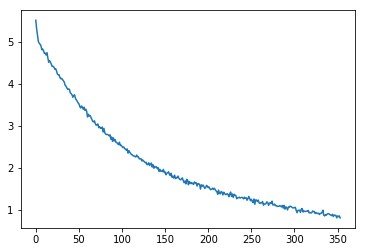

In [9]:
#####WARNING, THIS TAKES A WHILE

##Get all distortions
distortions = []
for i in range(1,int(len(list(bigdfVec))/2)):
    cb, dist = Cluster(bigdfVec, i)
    distortions.append(dist)
plt.plot(distortions)

It is easy to see the problem with just choosing the minimum here. The minimum will always be the same number of clusters as datapoints! This number of clusters isn't useful however, as having the same number of clusters as datapoints, is 100% overfitting. A common technique to combat this used alongside k-means, is finding when the maximum jump appears of inverted distortiong values. Below is the code to find the number of clusters when that point occurs. 

In [10]:
#Look for the maximum distortion jump. This should be our best k.

maxdistjump = 0
maxk = 0
for i in range(1, len(distortions)):
    if distortions[i] - distortions[i-1] > maxdistjump:
        maxdistjump = distortions[i] - distortions[i-1]
        maxk = i
        
print(maxk)
print(maxdistjump)

finalcb, finaldist = Cluster(bigdfVec, maxk)

175
0.10754409864487569


Now we have our theoretically best K value. Lets compute distances between each subreddit and cluster centers, then look at which subreddits are most in a specific cluster.

In [11]:
##compute distances between every subreddit and cluster centers for the best k we found

Clusterdistframe = pd.DataFrame(columns=list(bigdf)[1:])
for i in range(len(finalcb)):
    dists = []
    for v2 in bigdfVec:
        dists.append(distance.euclidean(finalcb[i], v2))
    Clusterdistframe.loc[i] = dists
Clusterdistframe.head()

NameError: name 'distance' is not defined

Now we can get the ten minimum and the ten maximum subreddits for each cluster

In [ ]:
mins = pd.DataFrame()
maxs = pd.DataFrame()
for index,row in Clusterdistframe.iterrows():
    mins[index] = list(Clusterdistframe.columns[row.argsort()][0:100])
    maxs[index] = list(Clusterdistframe.columns[row.argsort()][-99:])
    
mins=mins.transpose()
maxs=maxs.transpose()

In [ ]:
mins

In [ ]:
del maxs[2]
del maxs[3]
del maxs[4]
del maxs[5]
maxs

So theres a problem. By looking at this list we can see that there are unique clusters, but many of the clusters contain the same minimum subreddits, or they contain the same maximum subreddits. For example, there are many centroids very close to mildy_infuriating, which in and of itself is mildly infuriating. More importantly however, outliers appear to be super obvious. In that there are no cluster centers anywhere close to some subreddits, like Unity3D, and Denmark. Despite the fact that 297 clusters is mathematically the right number of clusters. It is harder to interpret on a human scale, so we also decided to guess a small number of clusters and look at the subreddits that appeared as minimums and maximums with less clusters.

In [ ]:
##cluster
guesscb, guessdist = Cluster(bigdfVec, 10)

##Get distances
guessClusterdistframe = pd.DataFrame(columns=list(bigdf)[1:])
for i in range(len(guesscb)):
    dists = []
    for v2 in bigdfVec:
        dists.append(distance.euclidean(guesscb[i], v2))
    guessClusterdistframe.loc[i] = dists

##Get mins and maxs
gmins = pd.DataFrame()
gmaxs = pd.DataFrame()
for index,row in guessClusterdistframe.iterrows():
    gmins[index] = list(guessClusterdistframe.columns[row.argsort()][0:100])
    gmaxs[index] = list(guessClusterdistframe.columns[row.argsort()][-99:])
    
gmins=gmins.transpose()
gmaxs=gmaxs.transpose()

In [ ]:
gmins

In [ ]:
del gmaxs[2]
del gmaxs[3]
del gmaxs[5]
gmaxs

These results are a little more interesting to look at, in that there is a significant difference between the minimum subreddits that appear in each cluster. The maximums still arent that interesting, as those outlier subreddits are still really far away. This distance could indicate that those subreddits have pretty isolated userbases, which honestly makes sense. Politics is a subreddit that appears at a very high distance from most other subreddits. This implies that lots of users post on politics, and only politics. Which is certainly very possible, and in fact very likely.

The next thing we thought would be interesting is to not only plot subreddits to cluster centers, but subreddits to eachother, to see total minimum distances and maximum distances between subreddits. 

In [12]:
from scipy.spatial import distance
##compute distances between every subreddit and put them in a massive table

distframe = pd.DataFrame(columns=list(bigdf)[1:])
for i in range(len(bigdfVec)):
    dists = []
    for v2 in bigdfVec:
        dists.append(distance.euclidean(bigdfVec[i], v2))
    distframe.loc[i] = dists
distframe.index = list(bigdf)[1:]
distframe

,cocktails,AskReddit,hearthstone,dontdeadopeninside,funny,TWWPRDT,vexillology,therewasanattempt,IntoTheBreach,news,...,blackcoin,Bergen,HighQualityReloads,EarlyPKA,saskatoon,collegeresults,lockn,WouldYouFuckMyWife,Schoolhouse,type2diabetes
cocktails,0.000000,103.754518,53.944416,72.449983,256.003906,1003.533258,52.649786,49.749372,76.935038,175.806712,...,57.930993,54.000000,72.304910,52.220686,54.662601,52.220686,61.506097,84.356387,54.323107,56.595053
AskReddit,103.754518,0.000000,90.293964,102.752129,247.707489,984.601442,88.943802,90.055538,105.697682,153.502443,...,94.968416,92.622891,104.359954,91.596943,92.601296,91.596943,97.190535,110.648091,89.654894,92.097774
hearthstone,53.944416,90.293964,0.000000,52.392748,258.862898,1001.366566,20.493902,32.817678,59.321160,164.590401,...,31.811947,23.916521,53.702886,19.570386,25.377155,19.570386,37.934153,65.084560,24.637370,27.622455
dontdeadopeninside,72.449983,102.752129,52.392748,0.000000,258.671606,1000.382927,52.602281,58.275209,76.170861,168.745370,...,57.887823,53.953684,72.270326,52.172790,54.616847,52.172790,61.465437,84.326745,54.277067,56.550862
funny,256.003906,247.707489,258.862898,258.671606,0.000000,951.753645,259.395451,243.903670,258.416331,194.581602,...,263.058929,262.221281,266.593323,261.860650,261.923653,259.482177,263.869286,266.112758,260.704814,261.669639
TWWPRDT,1003.533258,984.601442,1001.366566,1000.382927,951.753645,0.000000,1002.793598,993.843046,1001.976048,963.374797,...,1003.844111,1003.754452,1002.127237,1003.830663,1003.915833,1003.422144,1003.085241,1005.264642,1003.471973,1002.897801
vexillology,52.649786,88.943802,20.493902,52.602281,259.395451,1002.793598,0.000000,28.896367,56.062465,166.210710,...,29.563491,20.832667,52.402290,15.652476,22.494444,15.652476,36.069378,68.073490,21.656408,25.000000
therewasanattempt,49.749372,90.055538,32.817678,58.275209,243.903670,993.843046,28.896367,0.000000,59.514704,158.911925,...,40.137264,34.219877,59.016947,31.336879,34.713110,30.692019,45.144213,72.367120,30.886890,36.249138
IntoTheBreach,76.935038,105.697682,59.321160,76.170861,258.416331,1001.976048,56.062465,59.514704,0.000000,172.849646,...,63.411355,59.841457,76.765878,58.240879,60.440053,58.240879,66.693328,88.209977,60.133186,61.806149
news,175.806712,153.502443,164.590401,168.745370,194.581602,963.374797,166.210710,158.911925,172.849646,0.000000,...,170.827398,169.593632,174.922840,169.136040,169.570045,169.136040,168.234955,172.956642,166.910155,169.266063


In [14]:
sub_mins = pd.DataFrame()
sub_maxs = pd.DataFrame()
for index,row in distframe.iterrows():
    sub_mins[index] = list(distframe.columns[row.argsort()][0:100])
    sub_maxs[index] = list(distframe.columns[row.argsort()][-99:])
    
sub_mins=sub_mins.transpose()
sub_maxs=sub_maxs.transpose()

In [15]:
sub_mins

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cocktails,cocktails,lifehacks,boltedontits,QuakeChampions,NameThatSong,glitch_art,HappyEmbarrassedGirls,therewasanattempt,altgonewild,Washington,...,ketorecipes,worldbuilding,SugarPine7,IASIP,Edinburgh,PenmanshipPorn,nottheonion,DRZ400,awwwtf,BlackHairedGirls
AskReddit,AskReddit,thighhighs,keto,tipofmyjoystick,asmr,wikipedia,mycology,WhereDidTheSiloGo,SubredditDrama,ANormalDayInRussia,...,ghostbusters,Lottery,HelpMeFind,Bellingham,mturk,AskNYC,comicbooks,stevenuniverse,Gloomhaven,hockeyjerseys
hearthstone,hearthstone,asoiaf,atheism,prochoice,Hoocoodanode,kratom,PropagandaPosters,linux4noobs,nissanfrontier,forcedorgasms,...,humor,Honolulu,awwwtf,eu4,CollegeBasketball,darkestdungeon,tasker,RimWorld,nottheonion,cade
dontdeadopeninside,dontdeadopeninside,confessions,powerwashingporn,Charleston,ArtisanVideos,Tgirls,rap,Economics,c137,stormchasing,...,Animesuggest,glutenfree,NameThatSong,SolarCity,asklaw,vegan,mildlyinteresting,Jaguars,Portland,LegionTD2
funny,funny,stunfisk,news,NintendoSwitch,PerfectTiming,PublicFreakout,Overwatch,bicycling,HunterXHunter,pics,...,CyclePDX,indieheads,classiccars,AdventureBuilders,synology,Whatisthis,Juneau,ArtisanVideos,bostonceltics,SampleSize
TWWPRDT,TWWPRDT,stunfisk,Overwatch,pics,funny,Damnthatsinteresting,tifu,news,ramen,HomeNetworking,...,GooglePixel,recumbent,totallynotrobots,Michigan,RoomPorn,Cimmeria,bigdickproblems,shitpost,WhitePeopleTwitter,KingOfTheHill
vexillology,vexillology,Doom,DebateAnAtheist,comics,BirdsBeingDicks,Digibro,trailerparkboys,awesome,ketorecipes,koreanvariety,...,cade,RimWorld,tasker,blues,SugarPine7,CasualUK,worldbuilding,INEEEEDIT,corgibutts,holdmycosmo
therewasanattempt,therewasanattempt,gamedev,gtaonline,CinemaSins,boltedontits,newsokur,projectgorgon,farcry,HailCorporate,BirdsBeingDicks,...,humor,friendsafari,shorthairedhotties,MsBreezy,france,subnautica,LegalAdviceUK,Cooking,DIY,classiccars
IntoTheBreach,IntoTheBreach,NotHowGirlsWork,Weakpots,brasil,lastmansitting,hyperloop,HighschoolDxD,instant_regret,StarWarsBattlefront,Terraria,...,jobs,BreakUps,Animesuggest,SexyFrex,RoomPorn,HadToHurt,Israel,self,AdventureBuilders,Robocop
news,news,bicycling,NintendoSwitch,PokemonGoDenver,ForeverAlone,tipofmytongue,SubredditDrama,AskReddit,asmr,nba,...,farcry,Strava,worldbuilding,photography,kotor,Whatisthis,Lottery,intrusivethoughts,DigitalPainting,Terraria


In [17]:
sub_maxs.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
cocktails,MarkMyWords,linux_devices,ForeverAlone,WouldYouFuckMyWife,AsheronsCall,SWlegion,TheBullWins,NovaLauncher,Denmark,oddlysatisfying,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
AskReddit,Vaporwave,motorcitykitties,tall,TheFacebookDelusion,MarkMyWords,linux_devices,WouldYouFuckMyWife,witbox,digitaltabletop,Denmark,...,HomeNetworking,ONKPRDT,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
hearthstone,TheFacebookDelusion,motorcitykitties,ForeverAlone,linux_devices,AsheronsCall,SWlegion,TheBullWins,NovaLauncher,oddlysatisfying,Denmark,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
dontdeadopeninside,TheFacebookDelusion,motorcitykitties,MarkMyWords,linux_devices,Denmark,WouldYouFuckMyWife,ForeverAlone,AsheronsCall,SWlegion,TheBullWins,...,HomeNetworking,FL_Studio,ONKPRDT,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics
funny,interiordecorating,freedommobile,psychology,Breadit,opieandanthony,AskKrepo,DragonAgeCoOp,Whatcouldgowrong,4U9525,sanfrancisco,...,ImaginaryBehemoths,HomeNetworking,FL_Studio,WritingPrompts,lithuania,Unity3D,CodingandBilling,FullScorpion,TWWPRDT,politics


# Statistical Analysis

To perform statistical analysis on our data, we read in small data set. Both .csv files contain the same users. One file contains a user's comment frequency data, and the other contains that same user's submission frequency data.

In [ ]:
donaldc = pd.read_csv('donaldCFreq.csv')
donalds = pd.read_csv('donaldSFreq.csv')

print("DonaldCFreq:")
print(donaldc)
print("donaldSFreq:")
print(donalds)

In [ ]:
#dataframe for donaldc
donaldc["total_comments"] = donaldc.sum(axis = 1)
donaldc["total_comments"]

In [ ]:
#dataframe for donalds
donalds["total_submissions"] = donalds.sum(axis = 1)
donalds["total_submissions"]

In [ ]:
donaldCombined = pd.DataFrame()
donaldCombined["#Comments"] = donaldc["total_comments"]
donaldCombined["#Submissions"] = donalds["total_submissions"]
donaldCombined = donaldCombined.dropna()
donaldCombined

Delete submissions > 800:

In [ ]:
donaldCombined = donaldCombined[donaldCombined["#Submissions"] < 800] 
donaldCombined

Now, calculate Z scores to normalize the data, so we can perform statistical analysis.

In [ ]:
import scipy.stats

donaldCombined['#Comments_Z'] = scipy.stats.zscore(donaldCombined['#Comments'])
donaldCombined['#Submissions_Z'] = scipy.stats.zscore(donaldCombined['#Submissions'])

Scatter plot of Z scores:

In [ ]:
#scatter plot of Z scores
plt.scatter(donaldCombined['#Comments_Z'], donaldCombined['#Submissions_Z'])
plt.show

Run Pearson Correlation Coefficient to find correlation between two columns:

In [ ]:
donaldCombined['#Comments_Z'].corr(donaldCombined['#Submissions_Z'])

The correlation coefficient is about -0.25, making it somewhat anti-correlated. While this is not a very strong anti-correlation, it might still be assumed that users who comment a lot do not post submissions.